In [1]:
import os
import sys
sys.path.append("/users/ziyzhang/topology-research")
from topologies.DDF import DDFtopo
from nexullance.Nexullance_OPT import Nexullance_OPT
from nexullance.Nexullance_MP import Nexullance_MP
sys.path.append("/users/ziyzhang/topology-research/nexullance/IT_boost/build")
from Nexullance_IT_cpp import Nexullance_IT_interface
import globals as gl
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
config = (6,2)
V = config[0]
D = config[1]
EPR = (D+1)//2
_network = DDFtopo(V, D)
arcs = _network.generate_graph_arcs()

ASP, _ = _network.calculate_all_shortest_paths()
ECMP_ASP = gl.ECMP(ASP)

Cap_remote = 10 #GBps
Cap_local = 10 #GBps


/users/ziyzhang/miniconda3/envs/gt/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/users/ziyzhang/miniconda3/envs/gt/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


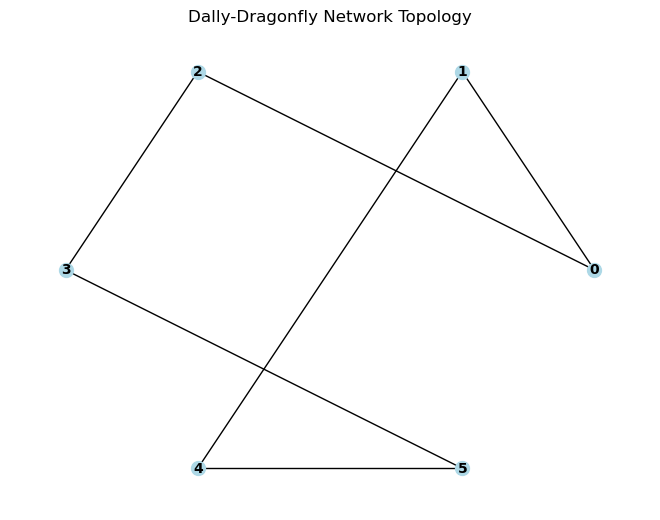

In [3]:
import networkx as nx

G=_network.nx_graph
# Draw the graph
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=100, node_color='lightblue', font_size=10, font_weight='bold')
plt.title("Dally-Dragonfly Network Topology")
plt.show()

In [4]:
ECMP_ASP

{(0, 1): [([0, 1], 1.0)],
 (0, 2): [([0, 2], 1.0)],
 (0, 3): [([0, 2, 3], 1.0)],
 (0, 4): [([0, 1, 4], 1.0)],
 (0, 5): [([0, 1, 4, 5], 0.5), ([0, 2, 3, 5], 0.5)],
 (1, 0): [([1, 0], 1.0)],
 (1, 2): [([1, 0, 2], 1.0)],
 (1, 3): [([1, 0, 2, 3], 0.5), ([1, 4, 5, 3], 0.5)],
 (1, 4): [([1, 4], 1.0)],
 (1, 5): [([1, 4, 5], 1.0)],
 (2, 0): [([2, 0], 1.0)],
 (2, 1): [([2, 0, 1], 1.0)],
 (2, 3): [([2, 3], 1.0)],
 (2, 4): [([2, 3, 5, 4], 0.5), ([2, 0, 1, 4], 0.5)],
 (2, 5): [([2, 3, 5], 1.0)],
 (3, 0): [([3, 2, 0], 1.0)],
 (3, 1): [([3, 2, 0, 1], 0.5), ([3, 5, 4, 1], 0.5)],
 (3, 2): [([3, 2], 1.0)],
 (3, 4): [([3, 5, 4], 1.0)],
 (3, 5): [([3, 5], 1.0)],
 (4, 0): [([4, 1, 0], 1.0)],
 (4, 1): [([4, 1], 1.0)],
 (4, 2): [([4, 5, 3, 2], 0.5), ([4, 1, 0, 2], 0.5)],
 (4, 3): [([4, 5, 3], 1.0)],
 (4, 5): [([4, 5], 1.0)],
 (5, 0): [([5, 4, 1, 0], 0.5), ([5, 3, 2, 0], 0.5)],
 (5, 1): [([5, 4, 1], 1.0)],
 (5, 2): [([5, 3, 2], 1.0)],
 (5, 3): [([5, 3], 1.0)],
 (5, 4): [([5, 4], 1.0)]}

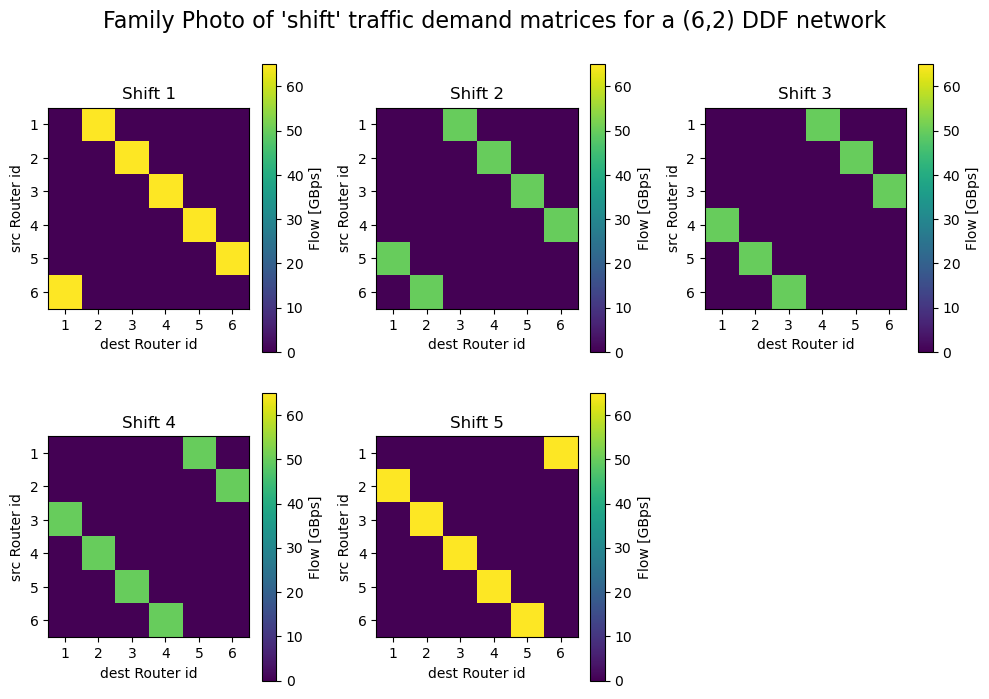

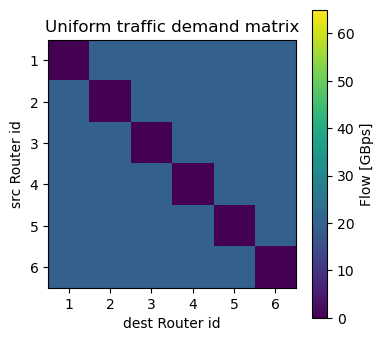

In [5]:
Shift_MEPs = []
# illustrating the traffic demand matrices:
# # generate a figure that will show the heapmaps of M_Rs for different shifts
plt.figure(figsize=(10, 20))
for _shift in range(1, V*EPR):
    M_EP = gl.generate_shift_traffic_pattern(V, EPR, _shift)
    # try to scale the traffic scaling factor to 10x saturation under ECMP_ASP
    remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, M_EP)
    max_remote_link_load = np.max(remote_link_flows)/Cap_remote
    max_local_link_load = np.max(local_link_flows)/Cap_local
    traffic_scaling = 10.0/max(max_local_link_load, max_remote_link_load)
    M_EP = traffic_scaling * M_EP
    M_R = gl.convert_M_EPs_to_M_R(M_EP, V, EPR)
    Shift_MEPs.append(M_EP)

    # use plt to generate heapmap for M_R, as a subfigure of the figure
    plt.subplot(V*EPR, 3, _shift)
    plt.imshow(M_R, cmap='viridis', aspect='equal', vmax= 65)
    plt.title(f'Shift {_shift}')
    plt.xlabel('dest Router id')
    plt.xticks(np.arange(V), np.arange(1, V + 1))
    plt.yticks(np.arange(V), np.arange(1, V + 1))
    plt.ylabel('src Router id')
    cbar = plt.colorbar()
    cbar.set_label('Flow [GBps]') 

plt.suptitle("Family Photo of 'shift' traffic demand matrices for a (6,2) DDF network", fontsize=16, y= 1.0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 4))
M_EP = gl.generate_uniform_traffic_pattern(V, EPR)
# try to scale the traffic scaling factor to 10x saturation under ECMP_ASP
remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, M_EP)
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
max_local_link_load = np.max(local_link_flows)/Cap_local
traffic_scaling = 10.0/max(max_local_link_load, max_remote_link_load)
Uniform_MEP = traffic_scaling * M_EP
Uniform_MR = gl.convert_M_EPs_to_M_R(Uniform_MEP, V, EPR)
# use plt to generate heapmap for M_R, as a subfigure of the figure
plt.xlabel('dest Router id')
plt.ylabel('src Router id')
plt.xticks(np.arange(V), np.arange(1, V + 1))
plt.yticks(np.arange(V), np.arange(1, V + 1))
plt.imshow(Uniform_MR, cmap='viridis', aspect='equal', vmax= 65)
plt.title(f'Uniform traffic demand matrix')
cbar = plt.colorbar()
cbar.set_label('Flow [GBps]') 

In [6]:
Shift_OPT_phis = []
Shift_ECMP_phis = []
for MEP_shift in Shift_MEPs:
    remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, MEP_shift)
    max_local_link_load = np.max(local_link_flows)/Cap_local

    Shift_ECMP_phis.append(gl.network_total_throughput(MEP_shift, np.max(remote_link_flows)/Cap_remote, max_local_link_load)/(V*EPR))

    nexu = Nexullance_OPT(_network.nx_graph, MEP_shift, Cap_remote, 0, False)
    nexu.init_model()
    Lremote_NEXU_OPT = nexu.solve()
    Shift_OPT_phis.append(gl.network_total_throughput(MEP_shift, Lremote_NEXU_OPT, max_local_link_load)/(V*EPR))

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter Lice

In [7]:
remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(ECMP_ASP, EPR, Uniform_MEP)
max_local_link_load = np.max(local_link_flows)/Cap_local

Uniform_ECMP_phi=gl.network_total_throughput(MEP_shift, np.max(remote_link_flows)/Cap_remote, max_local_link_load)/(V*EPR)
nexu = Nexullance_OPT(_network.nx_graph, Uniform_MEP, Cap_remote, 0, False)
nexu.init_model()
Lremote_NEXU_OPT = nexu.solve()
Uniform_OPT_phi = gl.network_total_throughput(Uniform_MEP, Lremote_NEXU_OPT, max_local_link_load)/(V*EPR)

# run Nexullance_MP
APST4, _ = _network.calculate_all_paths_within_length(4)
nexu = Nexullance_MP(_network.nx_graph, APST4, gl.convert_M_EPs_to_M_R(Uniform_MEP, V, EPR), Cap_remote, 0, False)
nexu.init_model()
Lremote_NEXU, MP_uniform_routing_table = nexu.solve()
Uniform_MP_phi = gl.network_total_throughput(Uniform_MEP, Lremote_NEXU, max_local_link_load)/(V*EPR)

# run Nexullance_IT
nexu_it = Nexullance_IT_interface(V, arcs, gl.convert_M_EPs_to_M_R(Uniform_MEP, V, EPR), False)
# nexu_it.set_parameters(4.6419767269134455, 6.593203706205871)
nexu_it.run()
Lremote_NEXU = nexu_it.get_max_link_load()
Uniform_IT_phi = gl.network_total_throughput(Uniform_MEP, Lremote_NEXU, max_local_link_load)/(V*EPR)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2411299
Academic license 2411299 - for non-commercial use only - registered to zi___@ugent.be
Set parameter Threads to value 1
Optimal solution found


In [8]:
import matplotlib.cm as cm
def plot_bench_bars(_data: dict, methods_name: list, title: str, x_label: str, y_label: str, y_log: bool = False, normalized: bool = False, _figsize=(15, 3)):

    # Calculate bar width dynamically based on the number of methods
    num_methods = len(methods_name)
    bar_width = 0.7 / num_methods  # Adjust this scaling factor as needed

    # Generating x positions for each group of bars
    x_positions = np.arange(len(_data))  

    # Generate colors using a predefined colormap
    colors = cm.tab10(np.linspace(0, 1, num_methods))

    # Plotting
    plt.figure(figsize=_figsize)  # Adjust size if necessary

    margin = 0.5
    plt.hlines(10.0, x_positions[0]-margin, x_positions[-1]+margin, colors="red")

    for i, method in enumerate(methods_name):
        # Extracting performance metrics for each method
        performance = [_data[bench][i] for bench in _data]
        # Adjusting x positions for each group of bars
        x_positions_adjusted = x_positions + (i - num_methods//2) * bar_width
        # Plotting bars for each method
        plt.bar(x_positions_adjusted, performance, width=bar_width, align='center', label=method, color = colors[i])
    # Adding labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # if normalized:
    #     plt.ylim(0, 1)
    if y_log:
        plt.yscale("log")  
    plt.title(title)

    x_ticks = [key.replace("_", "-") for key in _data.keys()]
    # x_ticks = [key.replace("-", "-\n") if key != "shift-1" else key for key in x_ticks]
    plt.xticks(x_positions, x_ticks)
    # Moving the legend outside the figure to the right
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)    
    plt.tight_layout()
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(x_positions[0]-margin, x_positions[-1]+margin)
    # plt.ylim(0, 11)

    # Show plot
    plt.show()

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("/users/ziyzhang/topology-research/Nexullance_journal_data_gen/MD_Nexullance/DDF_small_example/DDF_6_2_MD_all_shifts.csv")

In [11]:
plot_data={}
for i, _ in enumerate(Shift_MEPs):
    _shift = i+1
    raw_data = df[(df["included_M_R"]==f"shift_{_shift}")]
    plot_data[f"shift_{_shift}"] = [Shift_ECMP_phis[i], Shift_OPT_phis[i], raw_data["Phi_MP"].values[0]/(V*EPR), raw_data["Phi_MD_MP"].values[0]/(V*EPR), 
                                    raw_data["Phi_IT"].values[0]/(V*EPR), raw_data["Phi_MD_IT"].values[0]/(V*EPR)]


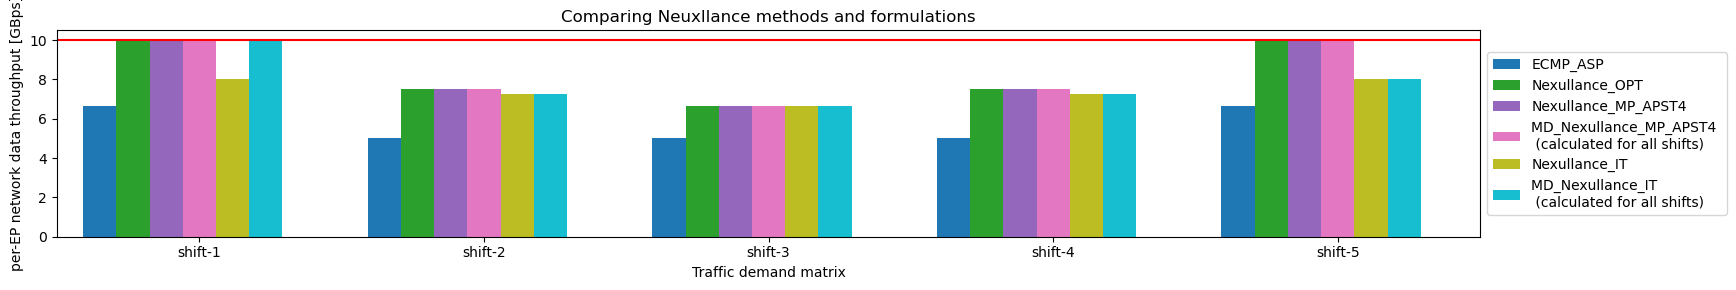

In [12]:
methods = ['ECMP_ASP', 'Nexullance_OPT', 'Nexullance_MP_APST4', 'MD_Nexullance_MP_APST4 \n (calculated for all shifts)', 
           'Nexullance_IT', 'MD_Nexullance_IT \n (calculated for all shifts)']
plot_bench_bars(plot_data, methods, "Comparing Neuxllance methods and formulations", 
                "Traffic demand matrix", "per-EP network data throughput [GBps]", y_log=False, normalized=False)

In [13]:
MD_MP_routing_table = pickle.load(open("./MD_NEXU_MP_APST_all_shifts_(6,2)DDFtopo_paths.pickle", 'rb'))
MD_IT_routing_table = pickle.load(open("./MD_NEXU_IT_all_shifts_(6,2)DDFtopo_paths.pickle", 'rb'))

remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(MD_MP_routing_table, EPR, M_EP)
max_local_link_load = np.max(local_link_flows)/Cap_local
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
MD_MP_uniform_phi = gl.network_total_throughput(M_EP, max_remote_link_load, max_local_link_load)/(V*EPR)

remote_link_flows, local_link_flows = _network.distribute_M_EPs_on_weighted_paths(MD_IT_routing_table, EPR, M_EP)
max_local_link_load = np.max(local_link_flows)/Cap_local
max_remote_link_load = np.max(remote_link_flows)/Cap_remote
MD_IT_uniform_phi = gl.network_total_throughput(M_EP, max_remote_link_load, max_local_link_load)/(V*EPR)

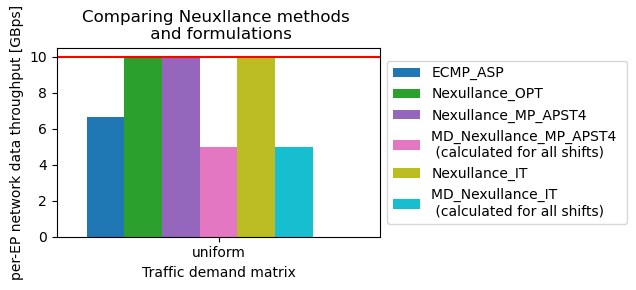

In [14]:
plot_data={}
plot_data["uniform"]=[Uniform_ECMP_phi, Uniform_OPT_phi,Uniform_MP_phi,MD_MP_uniform_phi,Uniform_IT_phi,MD_IT_uniform_phi]

methods = ['ECMP_ASP', 'Nexullance_OPT', 'Nexullance_MP_APST4', 'MD_Nexullance_MP_APST4 \n (calculated for all shifts)', 
           'Nexullance_IT', 'MD_Nexullance_IT \n (calculated for all shifts)']
plot_bench_bars(plot_data, methods, "Comparing Neuxllance methods \n and formulations", 
                "Traffic demand matrix", "per-EP network data throughput [GBps]", y_log=False, normalized=False, _figsize=(4,3))

In [15]:
gl.cal_weighted_ave_path_length(MD_MP_routing_table)

2.9555599999999997

In [16]:
gl.cal_weighted_ave_path_length(MP_uniform_routing_table)

2.8

In [17]:
MD_MP_routing_table

{(0, 1): [([0, 1], 1)],
 (0, 2): [([0, 2], 1)],
 (0, 3): [([0, 1, 4, 5, 3], 0.5), ([0, 2, 3], 0.5)],
 (0, 4): [([0, 1, 4], 0.3333), ([0, 2, 3, 5, 4], 0.6667)],
 (0, 5): [([0, 1, 4, 5], 0.0), ([0, 2, 3, 5], 1.0)],
 (1, 0): [([1, 0], 1)],
 (1, 2): [([1, 0, 2], 1.0)],
 (1, 3): [([1, 0, 2, 3], 0.3333), ([1, 4, 5, 3], 0.6667)],
 (1, 4): [([1, 4], 1)],
 (1, 5): [([1, 0, 2, 3, 5], 0.0), ([1, 4, 5], 1.0)],
 (2, 0): [([2, 0], 1)],
 (2, 1): [([2, 3, 5, 4, 1], 0.0), ([2, 0, 1], 1.0)],
 (2, 3): [([2, 3], 1)],
 (2, 4): [([2, 3, 5, 4], 0.3333), ([2, 0, 1, 4], 0.6667)],
 (2, 5): [([2, 3, 5], 1.0)],
 (3, 0): [([3, 2, 0], 0.5), ([3, 5, 4, 1, 0], 0.5)],
 (3, 1): [([3, 2, 0, 1], 0.3333), ([3, 5, 4, 1], 0.6667)],
 (3, 2): [([3, 2], 1)],
 (3, 4): [([3, 2, 0, 1, 4], 0.0), ([3, 5, 4], 1.0)],
 (3, 5): [([3, 5], 1)],
 (4, 0): [([4, 5, 3, 2, 0], 0.0), ([4, 1, 0], 1.0)],
 (4, 1): [([4, 1], 1)],
 (4, 2): [([4, 5, 3, 2], 0.3333), ([4, 1, 0, 2], 0.6667)],
 (4, 3): [([4, 5, 3], 1.0)],
 (4, 5): [([4, 5], 1)],
 (5, 0)

In [18]:
_network.distribute_M_R_on_weighted_paths(ECMP_ASP, gl.convert_M_EPs_to_M_R(Shift_MEPs[1], V, EPR))

{(0, 1): 25.0,
 (1, 0): 75.0,
 (0, 2): 75.0,
 (2, 0): 25.0,
 (1, 4): 50.0,
 (4, 1): 100.0,
 (2, 3): 50.0,
 (3, 2): 0.0,
 (3, 5): 75.0,
 (5, 3): 25.0,
 (4, 5): 25.0,
 (5, 4): 75.0}

In [22]:
_network.distribute_M_R_on_weighted_paths(ECMP_ASP, gl.convert_M_EPs_to_M_R(Shift_MEPs[0], V, EPR))

{(0, 1): 66.66666666666667,
 (1, 0): 100.0,
 (0, 2): 66.66666666666667,
 (2, 0): 33.333333333333336,
 (1, 4): 0.0,
 (4, 1): 33.333333333333336,
 (2, 3): 66.66666666666667,
 (3, 2): 33.333333333333336,
 (3, 5): 66.66666666666667,
 (5, 3): 33.333333333333336,
 (4, 5): 66.66666666666667,
 (5, 4): 100.0}

In [25]:
_network.distribute_M_R_on_weighted_paths(ECMP_ASP, gl.convert_M_EPs_to_M_R(Shift_MEPs[4], V, EPR))

{(0, 1): 100.0,
 (1, 0): 66.66666666666667,
 (0, 2): 33.333333333333336,
 (2, 0): 66.66666666666667,
 (1, 4): 33.333333333333336,
 (4, 1): 0.0,
 (2, 3): 33.333333333333336,
 (3, 2): 66.66666666666667,
 (3, 5): 33.333333333333336,
 (5, 3): 66.66666666666667,
 (4, 5): 100.0,
 (5, 4): 66.66666666666667}